## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import cv2
import random
#import mediapipe as mp
import os
import numpy as np
import string
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from PIL import Image
from collections import deque

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Proccessing

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# data path
data_path="data/asl_alphabet"
# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_path, transform=transform)

In [5]:
# Get class names
class_names = dataset.classes
num_classes = len(dataset.classes)
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [6]:
num_classes

29

In [7]:
# Split Data
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
# num of samples
num_train_samples = len(train_dataset)
num_test_samples = len(test_dataset)

print(f'Number of training samples: {num_train_samples}')
print(f'Number of testing samples: {num_test_samples}')

Number of training samples: 69600
Number of testing samples: 17400


In [9]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [50]:
# iterating over the training data
for images, labels in train_loader:
    
    print(images.shape, labels.shape)
    break

# iterating over the testing data
for images, labels in test_loader:
    
    print(images.shape, labels.shape)
    break

torch.Size([128, 3, 128, 128]) torch.Size([128])
torch.Size([128, 3, 128, 128]) torch.Size([128])


In [10]:
# display random sample
def show_random_samples(dataset, classes, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)  
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


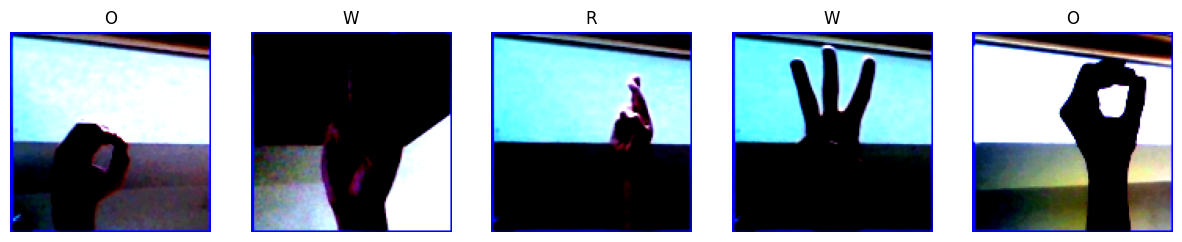

In [11]:
# random samples from the training set
show_random_samples(train_dataset, class_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


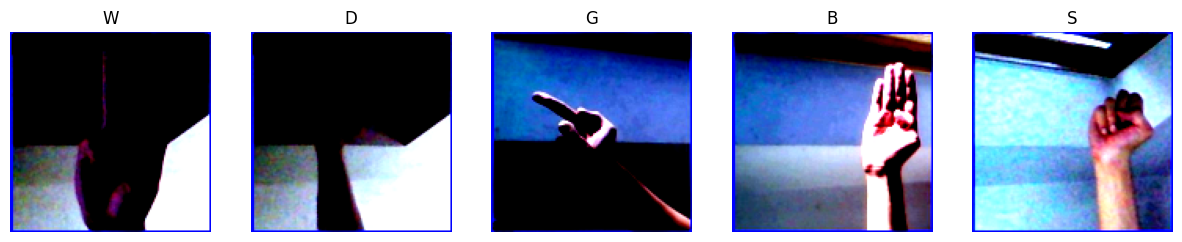

In [12]:
# random samples from the testing set
show_random_samples(test_dataset, class_names)

## Model Architecture

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self._to_linear = None
        self.convs_out(torch.randn(1, 3, 200, 200))  

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def convs_out(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        if self._to_linear is None:
            self._to_linear = x.view(1, -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs_out(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [12]:
# Instantiate and move the model to the GPU
my_model = SimpleCNN(num_classes=num_classes).to(device)

# Define loss function and optimizer
my_model_criterion = nn.CrossEntropyLoss()
my_model_optimizer = optim.Adam(my_model.parameters(), lr=0.001)

In [ ]:
summary(my_model, input_size=(3, 128,128))

####  AlexNet

In [27]:

AlexNet_model = models.alexnet(pretrained=True) 

# Freeze parameters
for param in AlexNet_model.parameters():
    param.requires_grad = False 

# Modify the last fully connected layer to fit your number of classes
AlexNet_model.classifier[6] = nn.Linear(4096, num_classes) 

# Move the model to the device (GPU) 
AlexNet_model.to(device) 

# Define loss function & optimizer
AlexNet_model_criterion = nn.CrossEntropyLoss() 
AlexNet_model_optimizer = optim.Adam(AlexNet_model.parameters(), lr=0.001)

summary(AlexNet_model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]          23,296
              ReLU-2           [-1, 64, 31, 31]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         307,392
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         590,080
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-14            [-1, 25

#### ResNet Model

In [28]:
# Load pre-trained Resnet model
resnet18_model = models.resnet18(pretrained=True)

# Freeze model parameters
for param in resnet18_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
num_classes = len(dataset.classes)

resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)

# Move the model to the device (GPU)
resnet18_model.to(device)

# Define loss function and optimizer
resnet18_model_criterion = nn.CrossEntropyLoss()
resnet18_model_optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)

summary(resnet18_model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

#### EfficientNet-B0

In [29]:
# Load pre-trained Resnet model
EffNet_model =models.efficientnet_b0(pretrained=True)

# Freeze model parameters
for param in EffNet_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
num_classes = len(dataset.classes)


EffNet_model.classifier[1] = nn.Linear(EffNet_model.classifier[1].in_features, num_classes)

# Move the model to the device (GPU)
EffNet_model.to(device)

# Define loss function and optimizer
EffNet_model_criterion = nn.CrossEntropyLoss()
EffNet_model_optimizer = optim.Adam(EffNet_model.parameters(), lr=0.001)

summary(EffNet_model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              SiLU-6           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 16, 64, 64]             512
      BatchNorm2d-14           [-1, 16,

## Traning

In [16]:
# Training loop

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        # Wrap the dataloader with tqdm
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)

        epoch_loss /= len(train_loader.dataset)
        print(f"\nEpoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


In [ ]:
my_model_loss=train_model(my_model, train_loader, my_model_criterion, my_model_optimizer, device, num_epochs=10)

### AlexNet Training

In [31]:
AlexNet_model_loss=train_model(AlexNet_model, train_loader, AlexNet_model_criterion, AlexNet_model_optimizer, device, num_epochs=10)

Epoch 1/10: 100%|██████████| 544/544 [20:21<00:00,  2.25s/it]



Epoch 1/10, Loss: 0.5198


Epoch 2/10: 100%|██████████| 544/544 [08:58<00:00,  1.01it/s]



Epoch 2/10, Loss: 0.2768


Epoch 3/10: 100%|██████████| 544/544 [02:39<00:00,  3.42it/s]



Epoch 3/10, Loss: 0.2406


Epoch 4/10: 100%|██████████| 544/544 [02:48<00:00,  3.23it/s]



Epoch 4/10, Loss: 0.2186


Epoch 5/10: 100%|██████████| 544/544 [06:41<00:00,  1.35it/s]



Epoch 5/10, Loss: 0.2164


Epoch 6/10: 100%|██████████| 544/544 [00:48<00:00, 11.31it/s]



Epoch 6/10, Loss: 0.2062


Epoch 7/10: 100%|██████████| 544/544 [00:50<00:00, 10.85it/s]



Epoch 7/10, Loss: 0.2003


Epoch 8/10: 100%|██████████| 544/544 [00:50<00:00, 10.76it/s]



Epoch 8/10, Loss: 0.1985


Epoch 9/10: 100%|██████████| 544/544 [00:50<00:00, 10.79it/s]



Epoch 9/10, Loss: 0.1971


Epoch 10/10: 100%|██████████| 544/544 [00:50<00:00, 10.88it/s]


Epoch 10/10, Loss: 0.1953


In [32]:
torch.save(AlexNet_model.state_dict(), "ASL_AlexNet_model.pth")


### ResNet Training

In [23]:
resnet18_model_loss=train_model(resnet18_model, train_loader, resnet18_model_criterion, resnet18_model_optimizer, device, num_epochs=10)

Epoch 1/10: 100%|██████████| 1088/1088 [27:13<00:00,  1.50s/it]



Epoch 1/10, Loss: 0.7412


Epoch 2/10: 100%|██████████| 1088/1088 [12:11<00:00,  1.49it/s]



Epoch 2/10, Loss: 0.2824


Epoch 3/10: 100%|██████████| 1088/1088 [12:21<00:00,  1.47it/s]



Epoch 3/10, Loss: 0.2072


Epoch 4/10: 100%|██████████| 1088/1088 [09:55<00:00,  1.83it/s]



Epoch 4/10, Loss: 0.1695


Epoch 5/10: 100%|██████████| 1088/1088 [01:10<00:00, 15.42it/s]



Epoch 5/10, Loss: 0.1482


Epoch 6/10: 100%|██████████| 1088/1088 [01:10<00:00, 15.34it/s]



Epoch 6/10, Loss: 0.1320


Epoch 7/10: 100%|██████████| 1088/1088 [01:12<00:00, 15.01it/s]



Epoch 7/10, Loss: 0.1217


Epoch 8/10: 100%|██████████| 1088/1088 [01:32<00:00, 11.75it/s]



Epoch 8/10, Loss: 0.1112


Epoch 9/10: 100%|██████████| 1088/1088 [01:10<00:00, 15.35it/s]



Epoch 9/10, Loss: 0.1041


Epoch 10/10: 100%|██████████| 1088/1088 [01:11<00:00, 15.24it/s]


Epoch 10/10, Loss: 0.0994


In [17]:
# Save ResNet18
torch.save(resnet18_model.state_dict(), 'ASL_ResNet18_model_V1.0.1.pth')

### EfficientNet-B0 Training

In [63]:
EffNet_model_loss=train_model(EffNet_model, train_loader, EffNet_model_criterion, EffNet_model_optimizer, device, num_epochs=10)

Epoch 1/10: 100%|██████████| 544/544 [22:22<00:00,  2.47s/it]



Epoch 1/10, Loss: 1.0435


Epoch 2/10: 100%|██████████| 544/544 [06:10<00:00,  1.47it/s]



Epoch 2/10, Loss: 0.4827


Epoch 3/10: 100%|██████████| 544/544 [09:21<00:00,  1.03s/it]



Epoch 3/10, Loss: 0.3807


Epoch 4/10: 100%|██████████| 544/544 [08:04<00:00,  1.12it/s]



Epoch 4/10, Loss: 0.3343


Epoch 5/10: 100%|██████████| 544/544 [06:36<00:00,  1.37it/s]



Epoch 5/10, Loss: 0.3076


Epoch 6/10: 100%|██████████| 544/544 [02:04<00:00,  4.37it/s]



Epoch 6/10, Loss: 0.2903


Epoch 7/10: 100%|██████████| 544/544 [06:24<00:00,  1.42it/s]



Epoch 7/10, Loss: 0.2816


Epoch 8/10: 100%|██████████| 544/544 [03:58<00:00,  2.28it/s]



Epoch 8/10, Loss: 0.2701


Epoch 9/10: 100%|██████████| 544/544 [01:37<00:00,  5.58it/s]



Epoch 9/10, Loss: 0.2645


Epoch 10/10: 100%|██████████| 544/544 [01:24<00:00,  6.45it/s]


Epoch 10/10, Loss: 0.2593


In [19]:
torch.save(EffNet_model.state_dict(), 'EffNet_model_V1.0.1.pth')

## Evaluation

In [20]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item() * inputs.size(0)

    accuracy = correct / total * 100
    epoch_loss = running_loss / total

    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return accuracy, epoch_loss

In [ ]:
my_model_accuracy=test_model(my_model, test_loader, my_model_criterion, device)

In [33]:
AlexNet_model_accuracy=test_model(AlexNet_model, test_loader, AlexNet_model_criterion, device)

Testing: 100%|██████████| 136/136 [05:01<00:00,  2.21s/it]

Test Loss: 0.0502, Test Accuracy: 98.34%


In [24]:
# Load the pre-trained ResNet18 model
resnet18_model = models.resnet18(pretrained=False)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 29)

resnet18_model.load_state_dict(torch.load('ASL_ResNet18_model_V1.0.1.pth', map_location=device))

resnet18_model.to(device)
resnet18_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18_model_accuracy=test_model(resnet18_model, test_loader, resnet18_model_criterion, device)

In [22]:
# load EffNet_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
EffNet_model = models.efficientnet_b0(pretrained=False) 
EffNet_model.classifier[1] = nn.Linear(EffNet_model.classifier[1].in_features, 29) 
EffNet_model.load_state_dict(torch.load('EffNet_model_V1.0.1.pth', map_location=device)) 
EffNet_model.to(device) 
EffNet_model.eval() 
print("EfficientNet model loaded")


c:\Users\MSI\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet model loaded


In [26]:
EffNet_model_accuracy=test_model(EffNet_model, test_loader, EffNet_model_criterion, device)

Testing: 100%|██████████| 136/136 [07:16<00:00,  3.21s/it]

Test Loss: 3.4252, Test Accuracy: 1.90%


## Visualiztion

In [34]:
def predict_and_display_image(model, image_path, transform, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Make a prediction
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
    
    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [ ]:
# visualize my_model
image_path = "D:\machine learning\Projects\Sign Language Using Photos\data\asl_alphabet_test\R_test.jpg"
predict_and_display_image(my_model, image_path, transform, device)

In [18]:
# load AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AlexNet_model = models.alexnet(pretrained=False)
AlexNet_model.classifier[6] = nn.Linear(4096, 29) 

AlexNet_model.load_state_dict(torch.load("ASL_AlexNet_model.pth", map_location=device))

AlexNet_model.to(device)
AlexNet_model.eval()

print("AlexNet model loaded")

c:\Users\MSI\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MSI\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet model loaded


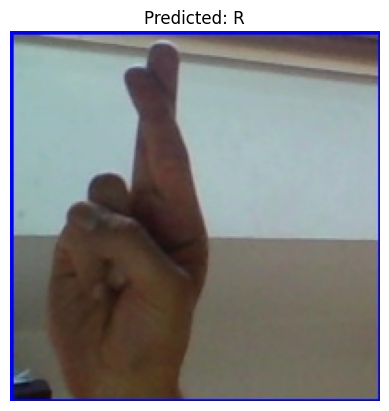

In [35]:
# visualize AlexNet_model
image_path = image_path = r"D:\machine learning\Projects\Sign Language Using Photos\data\asl_alphabet_test\R_test.jpg"
predict_and_display_image(AlexNet_model, image_path, transform, device)

In [19]:
# Load the pre-trained ResNet18 model
resnet18_model = models.resnet18(pretrained=False)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 29)

resnet18_model.load_state_dict(torch.load('ASL_ResNet18_model_V1.0.1.pth', map_location=device))

resnet18_model.to(device)
resnet18_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

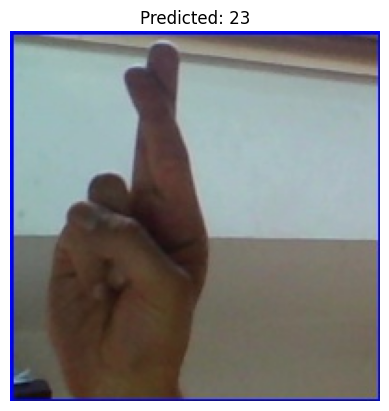

23

In [69]:
# visualize resnet18_model
image_path =r"D:\machine learning\Projects\Sign Language Using Photos\data\asl_alphabet_test\R_test.jpg"
predict_and_display_image(resnet18_model, image_path, transform, device)

In [20]:
# load EffNet_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
EffNet_model = models.efficientnet_b0(pretrained=False) 
EffNet_model.classifier[1] = nn.Linear(EffNet_model.classifier[1].in_features, 29) 
EffNet_model.load_state_dict(torch.load('EffNet_model_V1.0.1.pth', map_location=device)) 
EffNet_model.to(device) 
EffNet_model.eval() 
print("EfficientNet model loaded")


EfficientNet model loaded


In [ ]:
# visualize EffNet_model
image_path = r"D:\machine learning\Projects\Sign Language Using Photos\data\asl_alphabet_test\R_test.jpg"
predict_and_display_image(EffNet_model, image_path, transform, device)

## Real-Time Inference

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EffNet model
EffNet_model = models.efficientnet_b0(pretrained=False)
EffNet_model.classifier[1] = nn.Linear(EffNet_model.classifier[1].in_features, 29)
EffNet_model.load_state_dict(torch.load('EffNet_model_V1.0.1.pth', map_location=device))
EffNet_model.to(device)
EffNet_model.eval()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

classes = [chr(i) for i in range(65, 91)]  # A-Z
classes.append("del")
classes.append("nothing")
classes.append("space")

# 4. Voting buffer
prediction_queue = deque(maxlen=15)

# Real-time loop
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Flip
    frame = cv2.flip(frame, 1)

    # ROI
    h, w, _ = frame.shape
    x1, y1, x2, y2 = w//2 - 150, h//2 - 150, w//2 + 150, h//2 + 150
    roi = frame[y1:y2, x1:x2]

    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    input_tensor = transform(transforms.ToPILImage()(roi_rgb)).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = EffNet_model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        pred_class = classes[predicted.item()]

    # Add prediction to queue
    prediction_queue.append(pred_class)

    # Majority voting
    if len(prediction_queue) == prediction_queue.maxlen:
        final_pred = max(set(prediction_queue), key=prediction_queue.count)
    else:
        final_pred = pred_class

    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2.putText(frame, f"Prediction: {final_pred}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow("Real-time ASL Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load AlexNet model
AlexNet_model = models.alexnet(pretrained=False)
AlexNet_model.classifier[6] = nn.Linear(AlexNet_model.classifier[6].in_features, 29)
AlexNet_model.load_state_dict(torch.load("ASL_AlexNet_model.pth", map_location=device))
AlexNet_model.to(device)
AlexNet_model.eval()

transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

classes = [chr(i) for i in range(65, 91)]  # A-Z

# Voting buffer
prediction_queue = deque(maxlen=15)


cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)

    h, w, _ = frame.shape
    x1, y1, x2, y2 = w//2 - 150, h//2 - 150, w//2 + 150, h//2 + 150
    roi = frame[y1:y2, x1:x2]

    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    input_tensor = transform(Image.fromarray(roi_rgb)).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = AlexNet_model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        pred_class = classes[predicted.item()]

    prediction_queue.append(pred_class)

    if len(prediction_queue) == prediction_queue.maxlen:
        final_pred = max(set(prediction_queue), key=prediction_queue.count)
    else:
        final_pred = pred_class

    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(frame, f"Prediction: {final_pred}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow("Real-time ASL Prediction - AlexNet", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
